# Data Processing

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st

Extract

- Go through all the logs and extract the raw data
- skip empty logs that did not collect data

In [2]:
def extractLogs(dirpath: str, filename: str) -> pd.DataFrame:
    # Parse the dataframe from json
    df = pd.read_json(f"{dirpath}/{filename}", orient="index")
    df = df.reset_index(names="operation")

    # Re-orient the nested columns to tabularized data
    df = pd.concat(
        df.apply(
            lambda row: pd.DataFrame(
                [
                    # tabularize the baseline results
                    {
                        "operation": (
                            row.operation
                            if row.operation in ["create", "delete"]
                            else "execute"
                        ),
                        "sample": 0,
                        **row.baseline,
                        "response_time": row.response_time,
                    },
                    # tabularize the samples
                    *[
                        {
                            "operation": (
                                row.operation
                                if row.operation in ["create", "delete"]
                                else "execute"
                            ),
                            **{k: v for k, v in sample.items()},
                            "response_time": row.response_time,
                        }
                        for sample in row.samples
                    ],
                ]
            ),
            axis=1
        ).tolist(),
        ignore_index=True
    )

    # -- Get test information
    # from filename
    file_split = filename.split("_")
    fnc = file_split[0]
    iteration = int(file_split[2])
    db_size = int(file_split[4].split(".")[0])

    # from directory path
    dir_split = dirpath.split("/")[-1].split("\\")
    test_no = int(dir_split[0][0])
    test_type = dir_split[2]
    machine = dir_split[0][1:]

    # Set the entire column based on parsed data
    df["machine"] = machine
    df["db_type"] = test_type
    df["db_size"] = db_size
    df["test_no"] = test_no
    df["iteration"] = iteration
    
    # Eliminate sufix
    if (test_type == "structured"):
        df["function"] = fnc[:-6]
    else:
        df["function"] = fnc[:-8]

    # Set numeric columns
    df[[
        'db_size', 'test_no', 'iteration', 'sample', 'cpu_util',
        'disk_read', 'disk_write', 'disk_used', 'disk_free',
        'virtual_used', 'virtual_free', 'response_time'
    ]].astype(float)

    # Set the order of the table
    df = df[[
        "machine", "db_type", "function", "operation",
        "db_size", "test_no", "iteration", "sample", "cpu_util",
        "disk_read", "disk_write", "disk_used", "disk_free",
        "virtual_used", "virtual_free","response_time"
    ]]

    return df

def runExtract() -> pd.DataFrame:
    # go through all the files and save records
    results = []
    for dirpath, _, filenames in os.walk("../logs/"):
        for filename in filenames:
            if (filename.endswith(".json")):
                try:
                    # save files
                    r = extractLogs(dirpath, filename)
                    results.append(r)
                # ignore empty files
                except ValueError as e:
                    continue

    # combine and print
    return pd.concat(results)

e_df = runExtract()
e_df

,machine,db_type,function,operation,db_size,test_no,iteration,sample,cpu_util,disk_read,disk_write,disk_used,disk_free,virtual_used,virtual_free,response_time
0,medium,structured,aggregate,delete,10,0,0,0,52.4,1.443598,28.730371,5.063541,22.938534,3.021351,0.725601,0.001020
1,medium,structured,aggregate,delete,10,0,0,1,50.0,1.443598,28.730375,5.063545,22.938530,3.021343,0.725609,0.001020
2,medium,structured,aggregate,create,10,0,0,0,60.0,1.443598,28.730459,5.063854,22.938221,3.021057,0.725895,0.028347
3,medium,structured,aggregate,create,10,0,0,1,85.0,1.443606,28.730967,5.064682,22.937393,3.020138,0.726814,0.028347
4,medium,structured,aggregate,execute,10,0,0,0,57.1,1.443606,28.748194,5.064682,22.937393,3.020008,0.726944,0.001489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,smalls,unstructured,insertOne,create,1000000,4,2,43,65.0,1.893312,4.040453,4.035873,23.966202,1.833820,0.032047,21.681869
46,smalls,unstructured,insertOne,create,1000000,4,2,44,75.0,1.893312,4.049124,4.039600,23.962475,1.835991,0.029877,21.681869
47,smalls,unstructured,insertOne,create,1000000,4,2,45,9.5,1.893781,4.050531,4.040947,23.961128,1.796898,0.068970,21.681869
48,smalls,unstructured,insertOne,execute,1000000,4,2,0,5.0,1.893956,4.050531,4.040947,23.961128,1.796806,0.069061,0.006187


Transform
- each operation samples the resources, aggregate the samples and store them as one value
- use average for cpu usage and response time
- use max and min for memory usage (disk and RAM)

In [3]:
def transformFrame(df: pd.DataFrame) -> pd.DataFrame:
    # groups by the sample in each iteration
    df = (
        df
        .groupby(["machine", "db_type","function","operation","db_size","test_no","iteration"])
        .agg({
            "cpu_util": "median",
            "disk_read": "max",
            "disk_write": "max",
            "disk_used": "max",
            "disk_free": "min",
            "virtual_used": "max",
            "virtual_free": "min",
            "response_time": "mean"
            })
    )

    return df.reset_index()

t_df = transformFrame(e_df.copy(deep=True))
t_df

,machine,db_type,function,operation,db_size,test_no,iteration,cpu_util,disk_read,disk_write,disk_used,disk_free,virtual_used,virtual_free,response_time
0,medium,structured,aggregate,create,10,0,0,72.50,1.443606,28.730967,5.064682,22.937393,3.021057,0.725895,0.028347
1,medium,structured,aggregate,create,10,0,1,52.75,1.443606,28.750166,4.967445,23.034630,3.023819,0.723133,0.019826
2,medium,structured,aggregate,create,10,0,2,53.95,1.443606,28.751482,4.925236,23.076839,3.033745,0.713207,0.022511
3,medium,structured,aggregate,create,10,0,3,53.55,1.443606,28.751787,4.925247,23.076828,3.033710,0.713242,0.019926
4,medium,structured,aggregate,create,10,0,4,53.70,1.443606,28.752035,4.925262,23.076813,3.033680,0.713272,0.019918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14701,smalls,unstructured,updateOne,execute,100000,4,0,20.00,0.325700,1.493464,4.375790,23.626286,1.142704,0.723164,0.082442
14702,smalls,unstructured,updateOne,execute,100000,4,1,23.70,0.325704,1.503073,4.385948,23.616127,1.137939,0.727928,0.103406
14703,smalls,unstructured,updateOne,execute,100000,4,2,22.50,0.325738,1.572260,3.821026,24.181049,1.056908,0.808960,0.078894
14704,smalls,unstructured,updateOne,execute,100000,4,3,19.05,0.325738,1.581869,3.833317,24.168758,1.062370,0.803497,0.076084


Confidence Interval
- uses block mean
    - each iteration is run consequtively so there is some dependancy
    - each test is run after all other tests have been run so they are independant
    - block mean: calculate the mean for the dependentant results then the mean of the independant
    - reduces the sample size so the confidence interval has a larger range
- function is used to extract the confidence interval for a single metric at a time

In [4]:
# Treat iterations as dependant and tests as independant
def blockCI(
        df: pd.DataFrame,
        value_col: str,
        alpha: float=0.05,
        execute_only: bool=True
    ) -> pd.DataFrame:

    if execute_only:
        df = df[df["operation"] == "execute"]
        group = ['machine','db_type','function','db_size']
    else:
        df = df[df["operation"] != "execute"]
        group = ['machine','db_type','operation','db_size']


    # iteration mean
    iter_df = (
        df
        .groupby(['machine','db_type','function','operation','db_size','test_no'])[value_col]
        .mean()
        .reset_index(name='iter_mean')
    )
    
    # mean within between tests
    test_df = (
        iter_df
        .groupby(group)['iter_mean']
        .agg(['mean','std','count'])
        .reset_index()
    )

    # standard error
    test_df['se'] = test_df['std'] / np.sqrt(test_df['count'])

    # get t value for sample
    test_df['t'] = test_df['count'].apply(lambda n: st.t.ppf(1 - alpha/2, df=n-1))

    # error
    test_df['error'] = test_df['se'] * test_df['t']

    # CI - lower and upper bounds
    test_df['ci_lower'] = test_df['mean'] - test_df['error']
    test_df['ci_upper'] = test_df['mean'] + test_df['error']

    # filter columns
    test_df = test_df[group + ['mean','ci_lower','ci_upper']]

    return test_df

# Treat all iterations as independant
def CI(
        df: pd.DataFrame,
        group: list,
        value_col: str,
        alpha: float=0.05
    ) -> pd.DataFrame:
    
    # mean within between tests
    test_df = (
        df
        .groupby(group)[value_col]
        .agg(['mean','std','count'])
        .reset_index()
    )

    # standard error
    test_df['se'] = test_df['std'] / np.sqrt(test_df['count'])

    # get t value for sample
    test_df['t'] = test_df['count'].apply(lambda n: st.t.ppf(1 - alpha/2, df=n-1))

    # error
    test_df['error'] = test_df['se'] * test_df['t']

    # CI - lower and upper bounds
    test_df['ci_lower'] = test_df['mean'] - test_df['error']
    test_df['ci_upper'] = test_df['mean'] + test_df['error']

    # filter columns
    test_df = test_df[group + ['mean','ci_lower','ci_upper']]

    return test_df

# Analysis

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

Overview

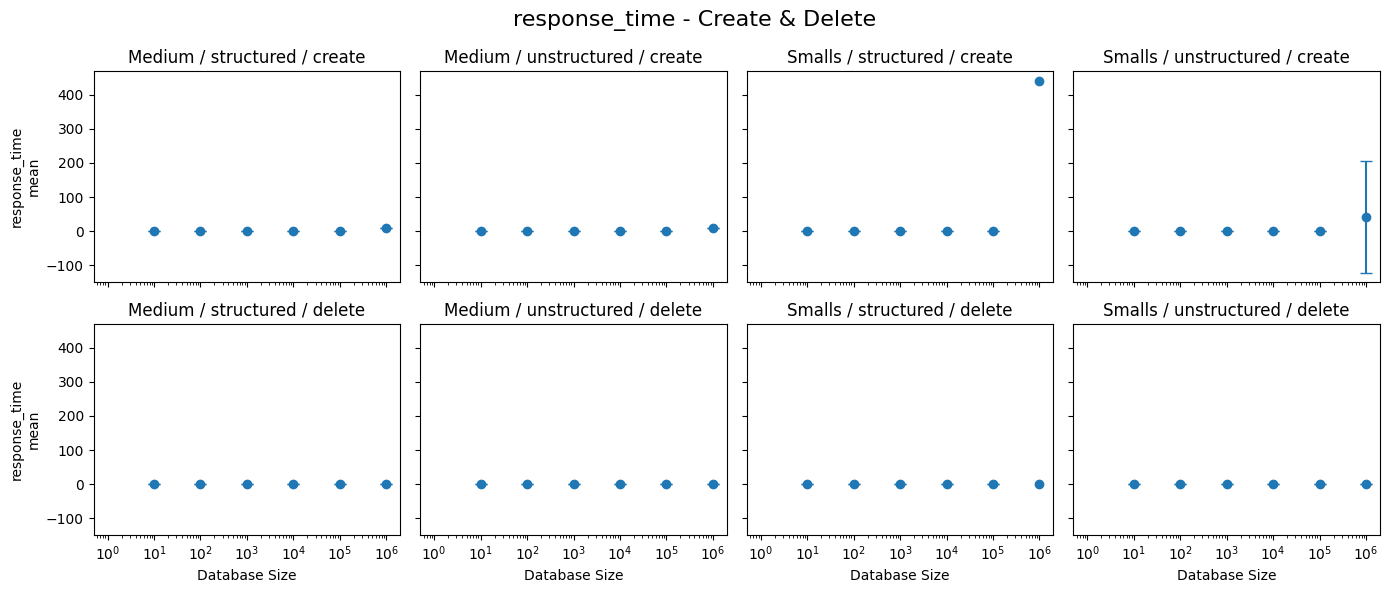

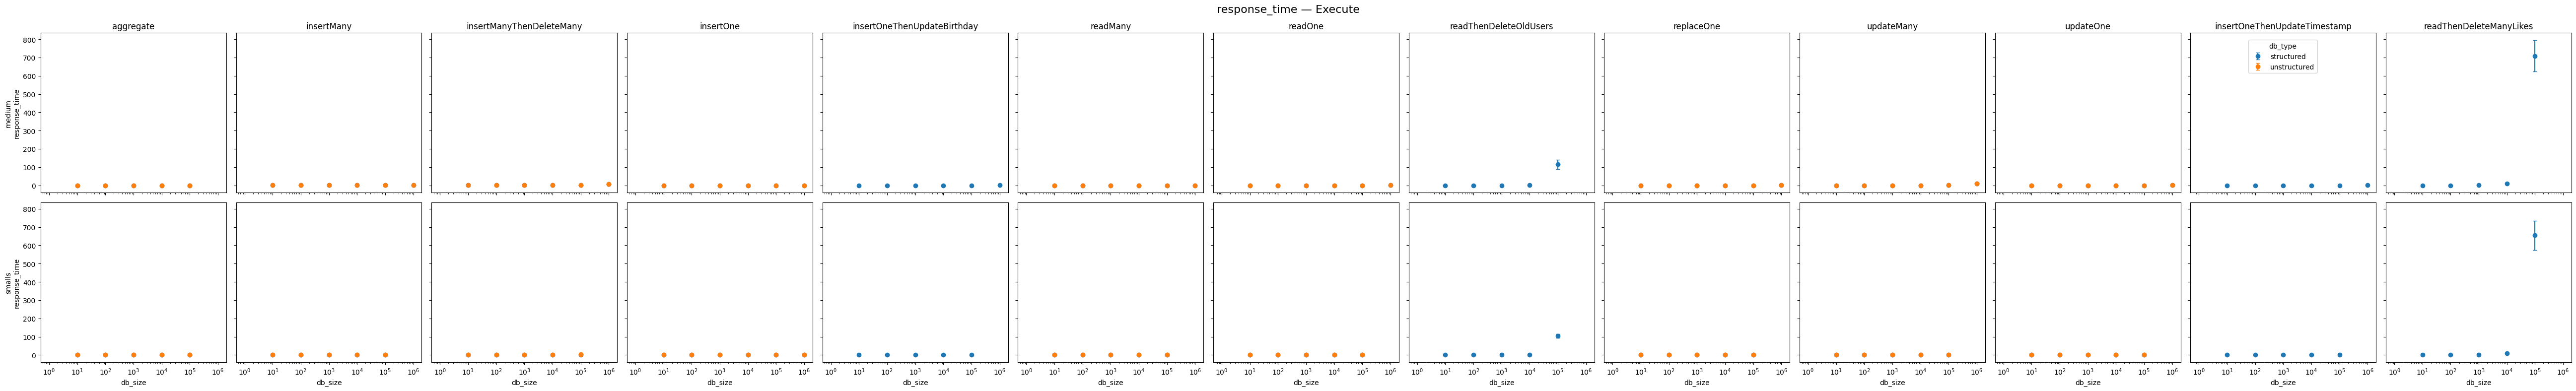

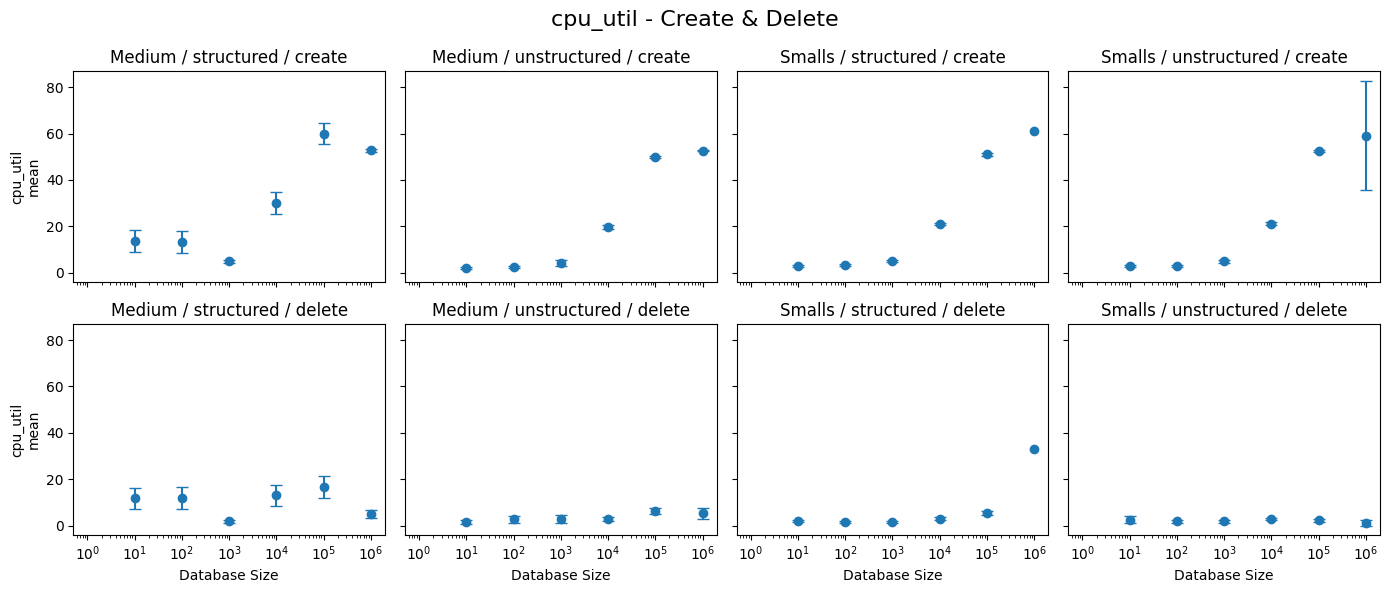

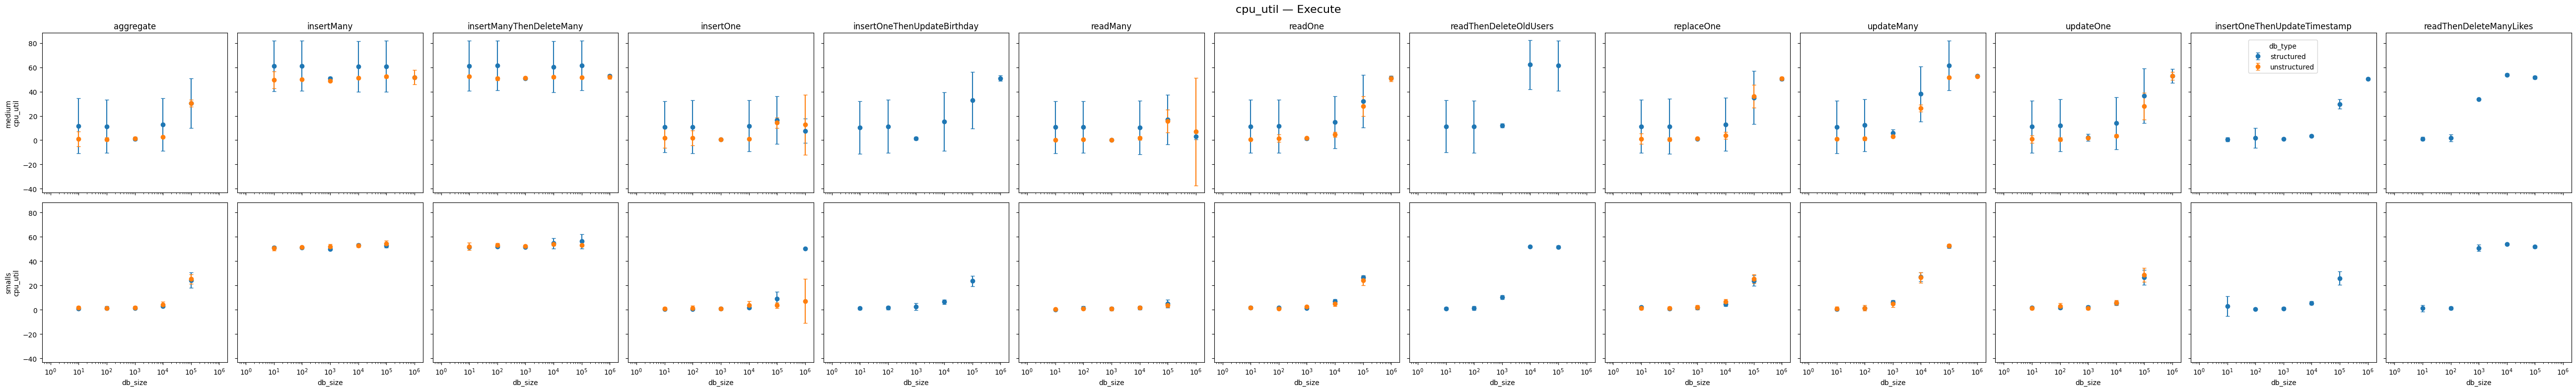

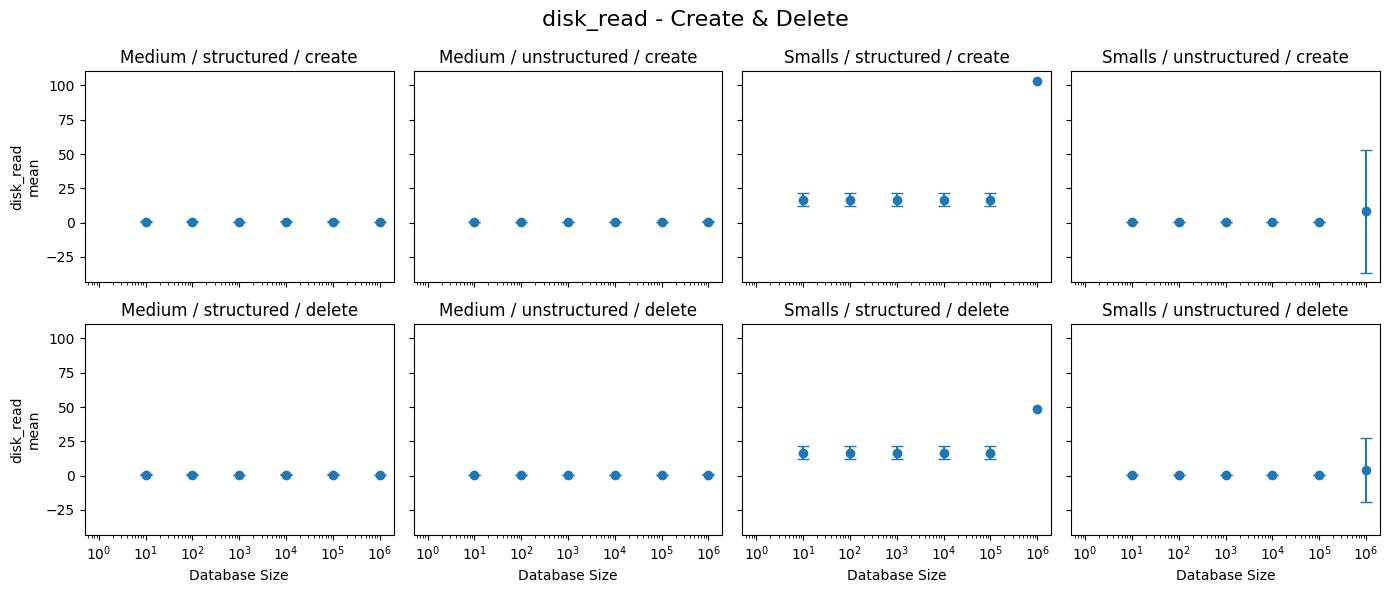

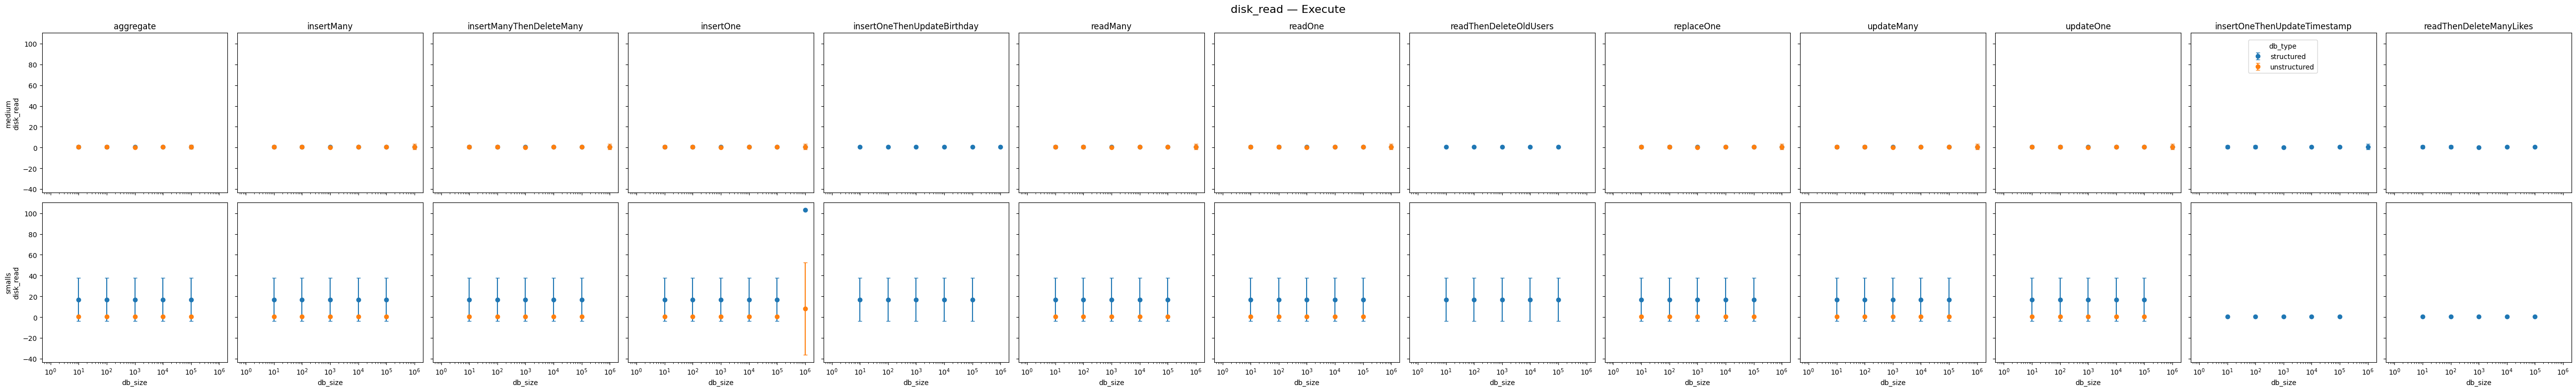

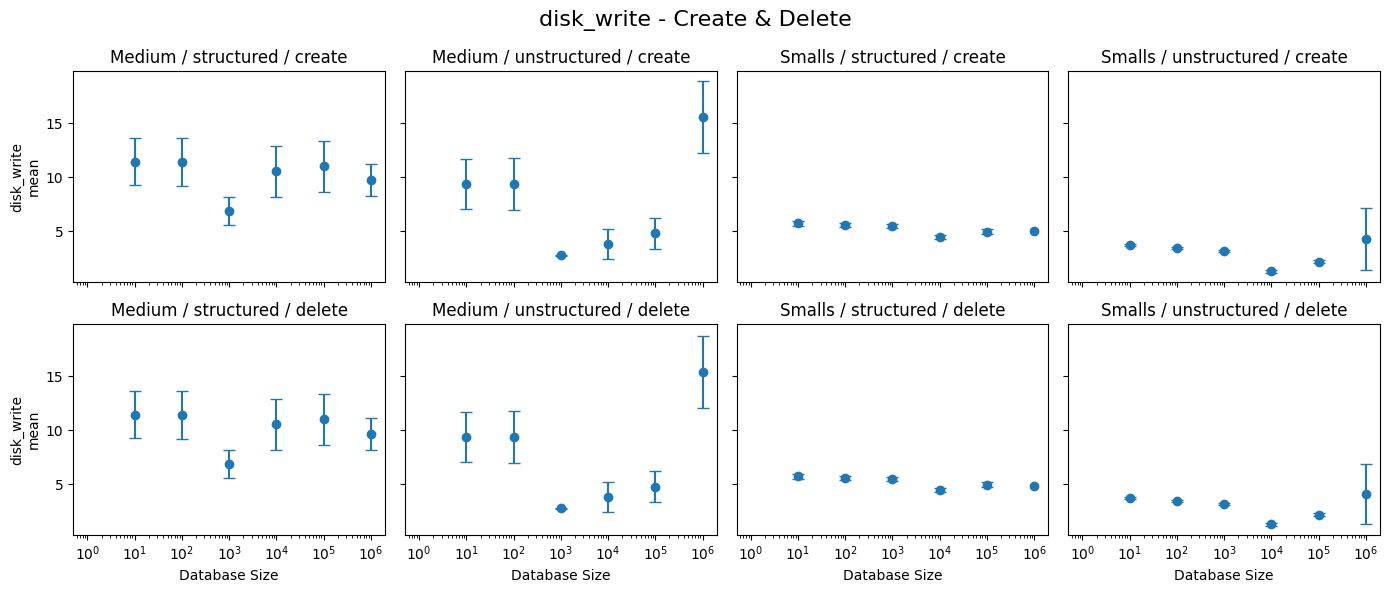

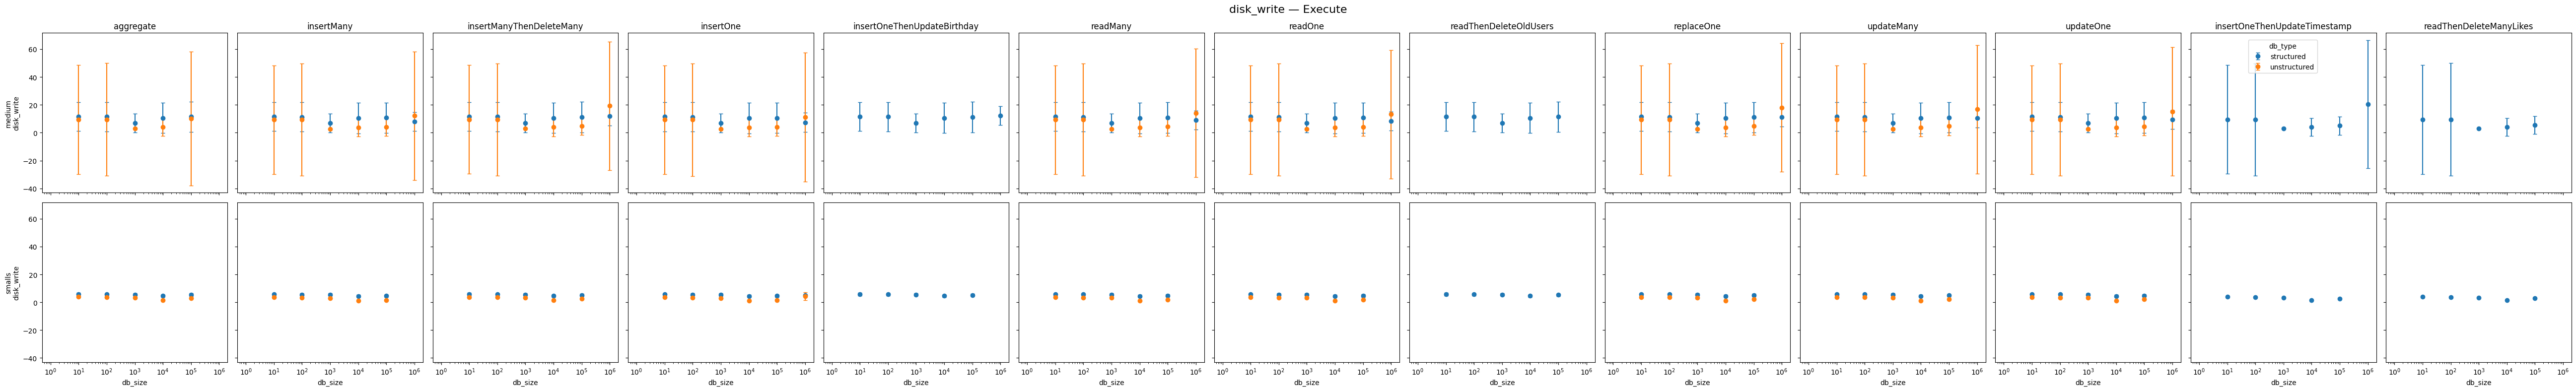

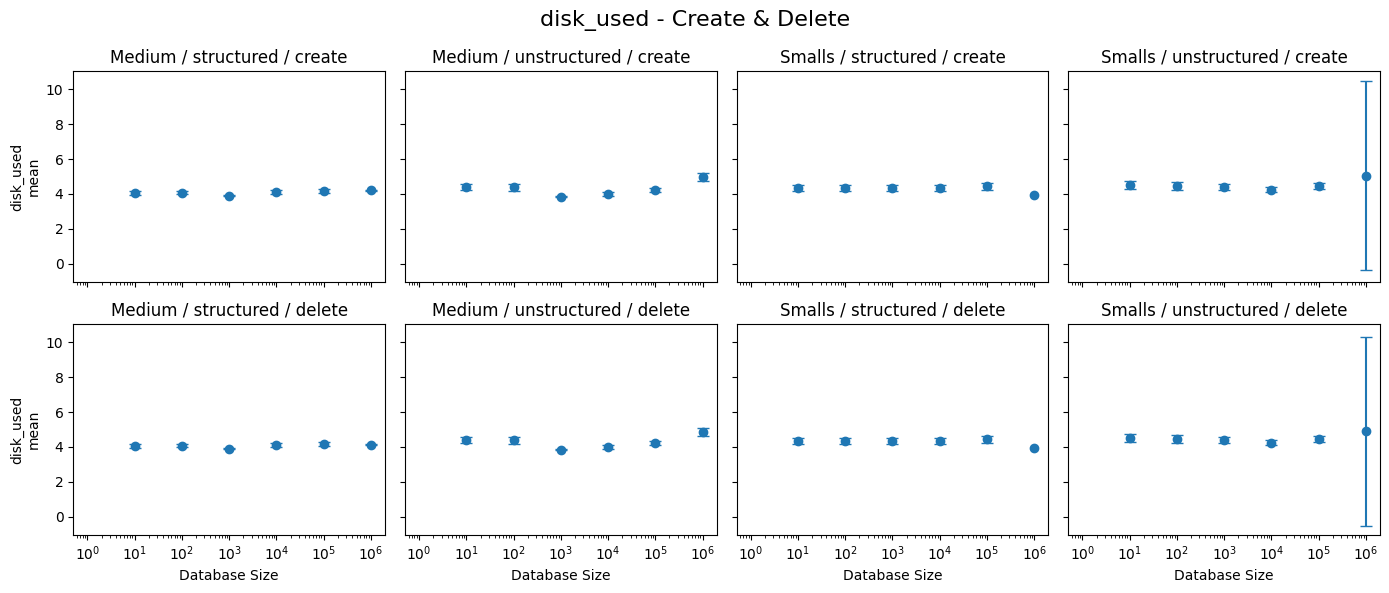

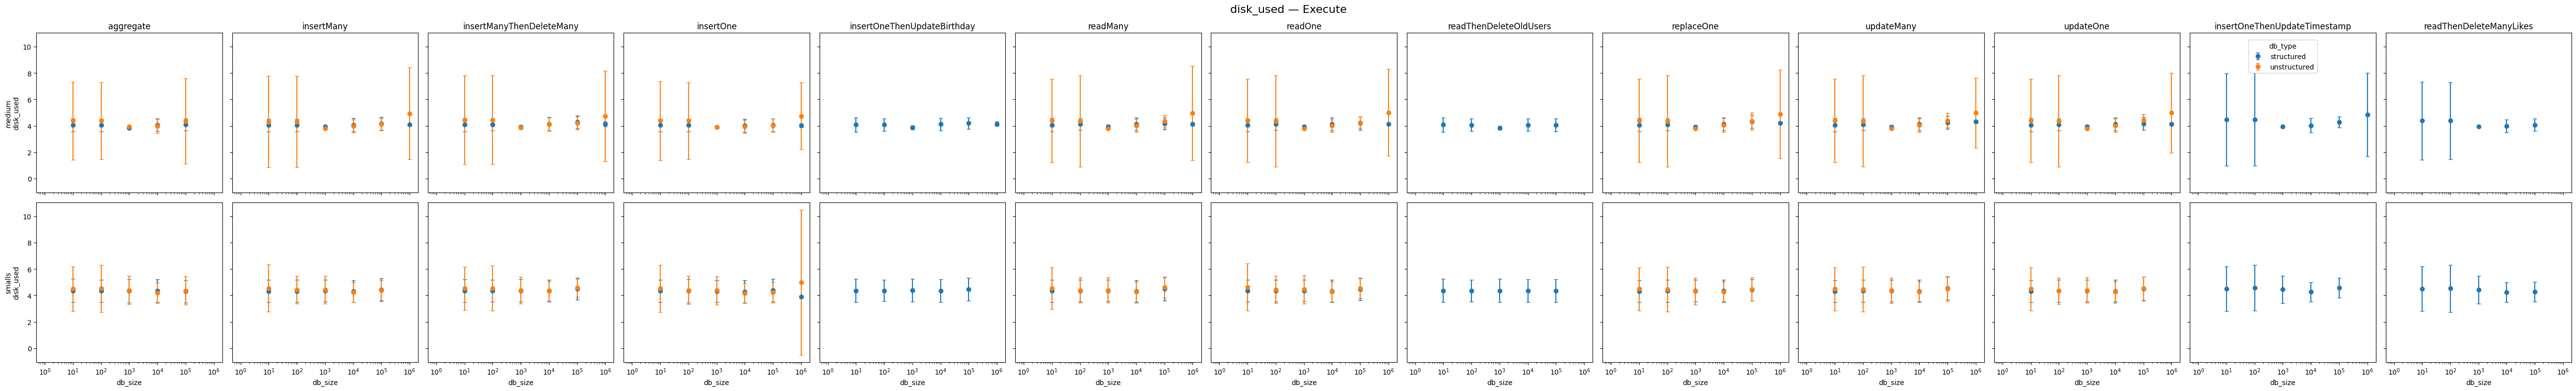

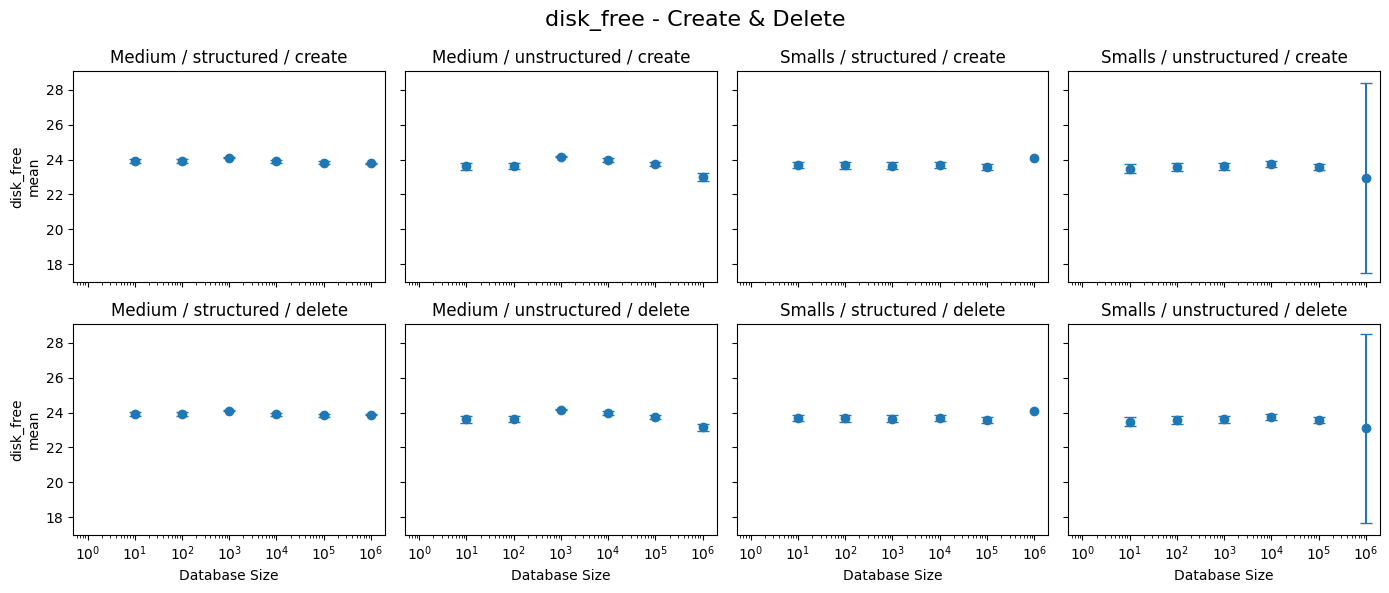

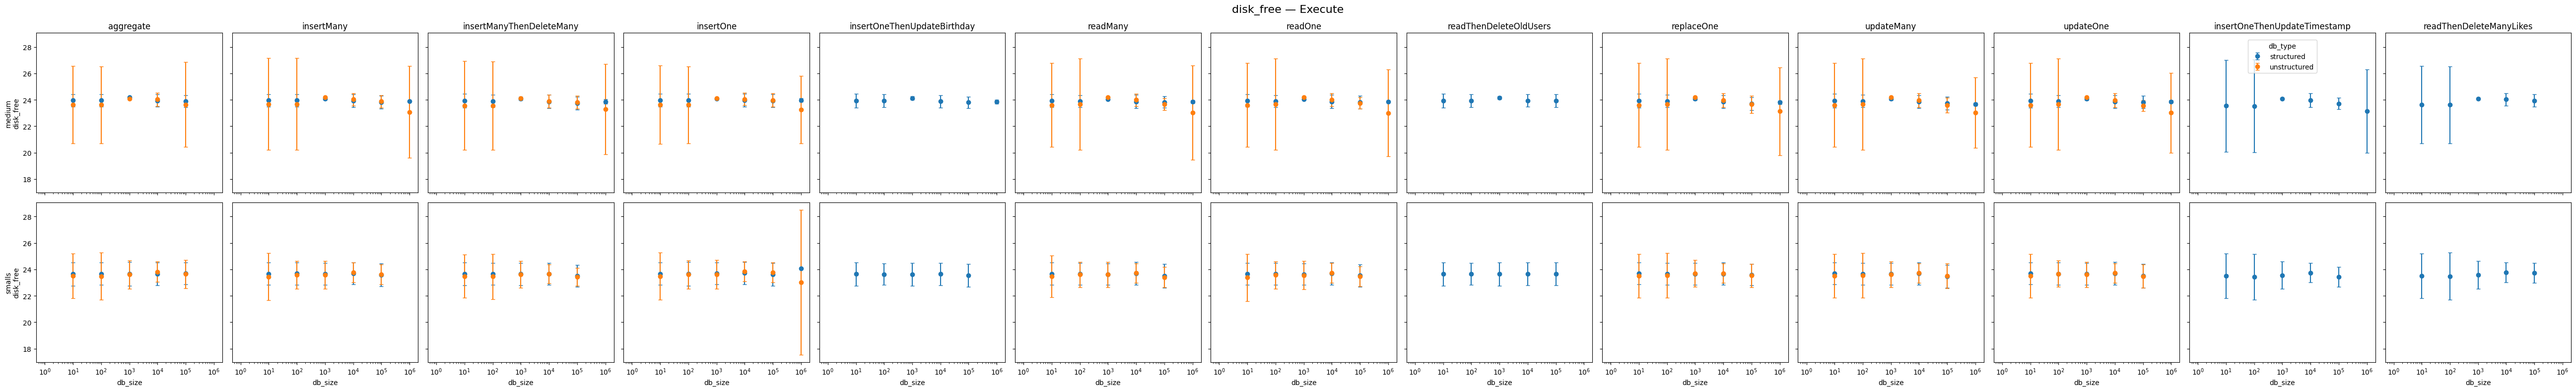

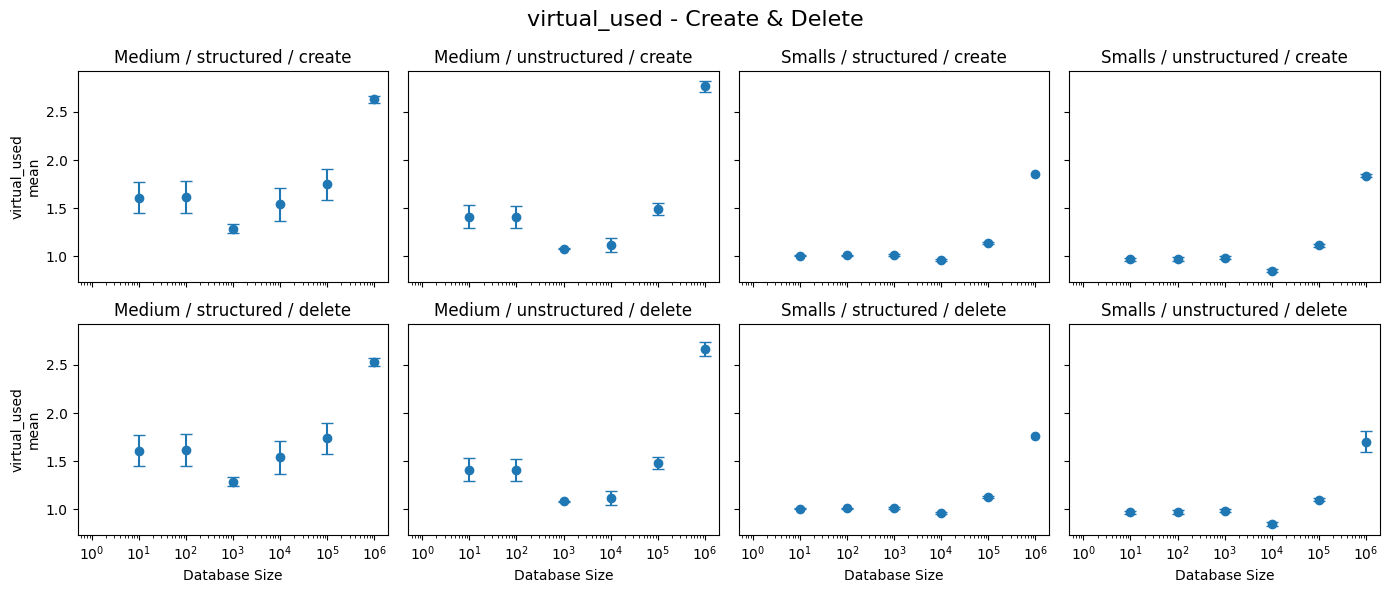

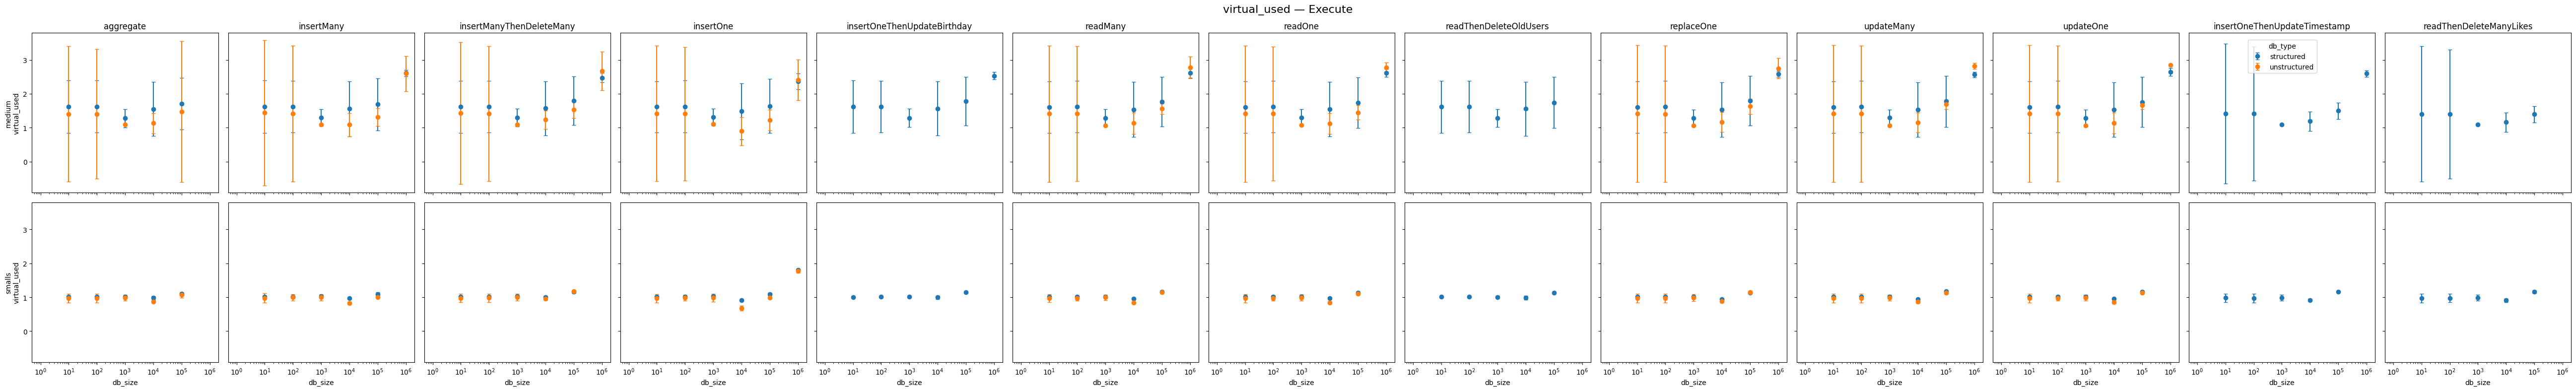

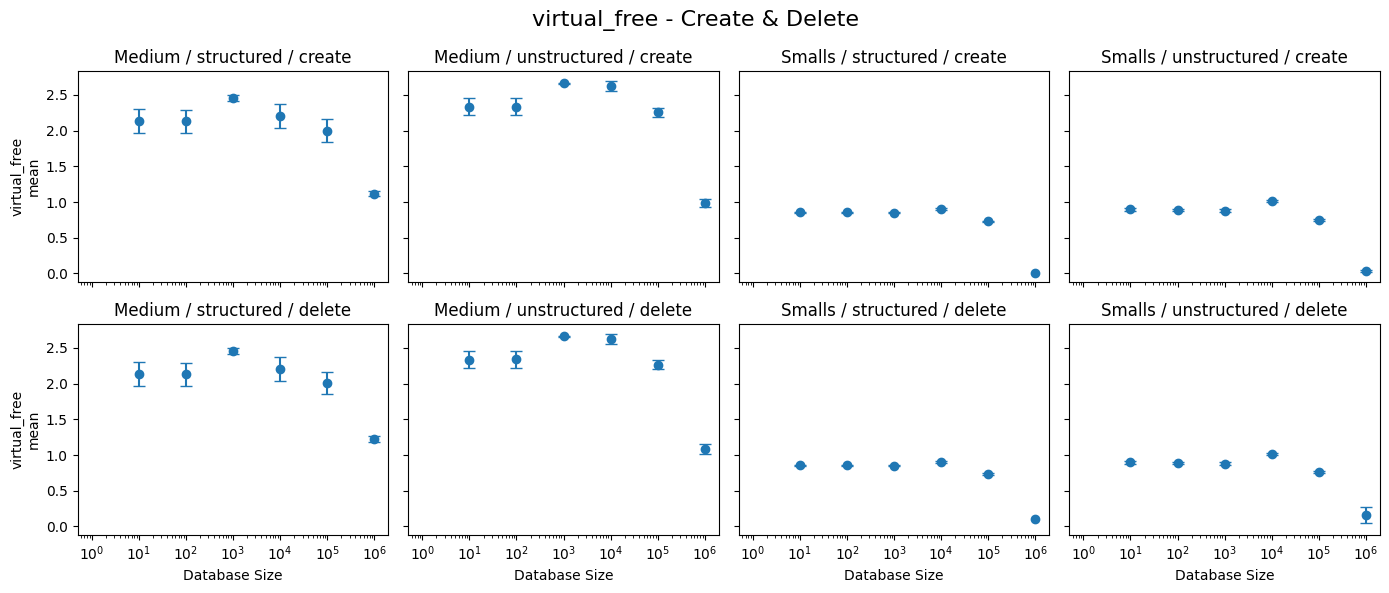

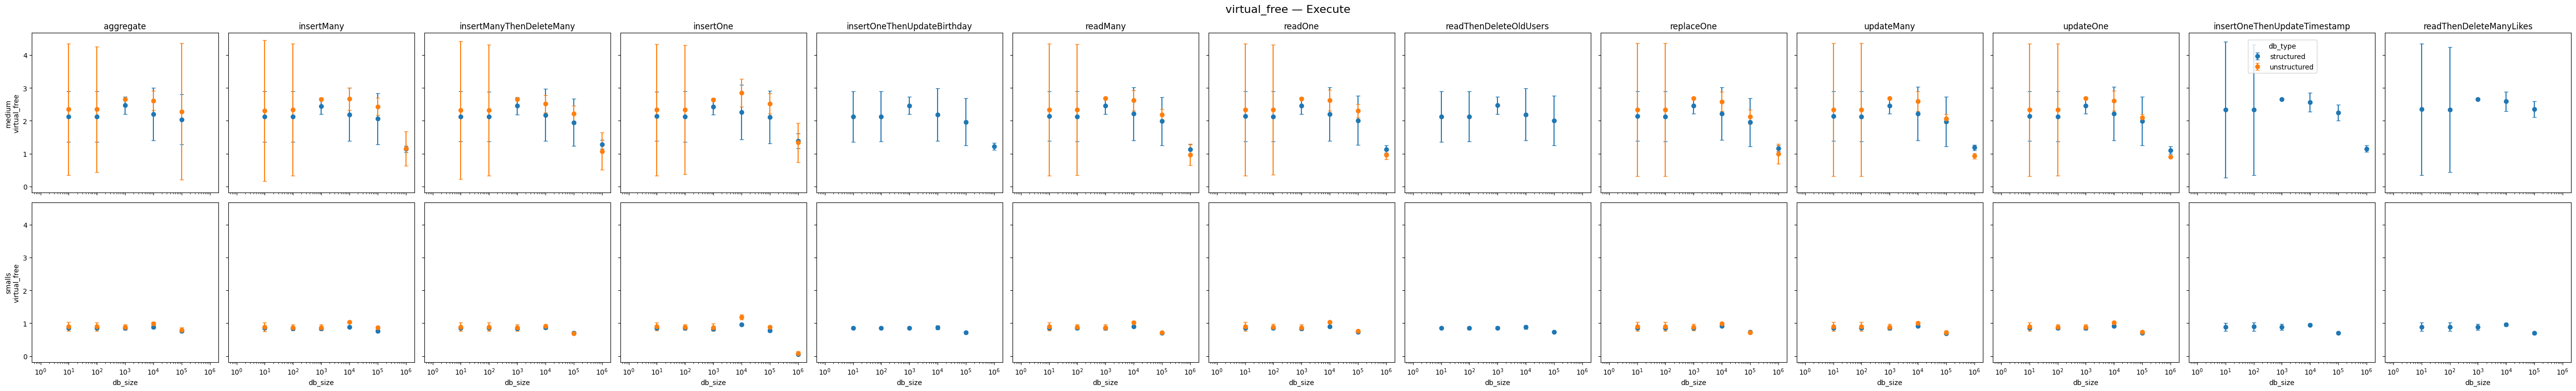

In [6]:
def plotOverview():
    # measurements to visualize
    metrics = [
        'response_time', "cpu_util", 
        'disk_read', 'disk_write',
        'disk_used', 'disk_free',
        'virtual_used', 'virtual_free',
    ]

    # CD operations
    operations = ['create', 'delete']

    # instances 4 GiB and 2 GiB
    machines   = ['medium', 'smalls']

    # types of data
    db_types   = ['structured', 'unstructured']

    # plot create/delete
    def plot_cd_metric(df: pd.DataFrame, metric: str):
        # get subplots
        fig, axes = plt.subplots(
            nrows=len(operations),
            ncols=len(machines) * len(db_types),
            figsize=(14, 6),
            sharex=True,
            sharey=True
        )

        # go through create and delete
        for i, op in enumerate(operations):
            # tracks the index of the subplot column
            j = 0

            # go through instance and data type
            for machine in machines:
                for dbt in db_types:

                    # select plot
                    ax = axes[i, j]

                    # sub data frame
                    sub = df[
                        (df['operation'] == op) &
                        (df['machine']   == machine) &
                        (df['db_type']   == dbt)
                    ]

                    # ignore empty data sets
                    if sub.empty:
                        ax.set_visible(False)
                    else:
                        # mean values
                        y = sub['mean']

                        # set the error bar based on the delta between mean and confidence intervals
                        yerr = [y - sub['ci_lower'], sub['ci_upper'] - y]

                        # set the error bar
                        ax.errorbar(
                            sub['db_size'],
                            y,
                            yerr=yerr,
                            fmt='o',
                            capsize=4
                        )

                        # format subplot
                        ax.set_title(f"{machine.capitalize()} / {dbt} / {op}", pad=6)
                        ax.set_xscale('log')

                    # Set x label
                    if i == len(operations) - 1:
                        ax.set_xlabel('Database Size')
                    
                    # set y label
                    if j == 0:
                        ax.set_ylabel(f"{metric}\nmean")
                    
                    # increment subplot
                    j += 1

        # set the title for entire subplot
        fig.suptitle(f"{metric} - Create & Delete", fontsize=16)

        plt.tight_layout()
        plt.show()

    # plot how metric behaves as size increases wrt functions executed
    def plot_ex_metric(df: pd.DataFrame, metric: str):
        functions = df['function'].unique().tolist()

        # create subplots
        fig, axes = plt.subplots(
            nrows=len(machines),
            ncols=len(functions),
            figsize=(4 * len(functions), 4 * len(machines)),
            sharex=True,
            sharey=True
        )

        # go through instances and the functions
        for i, machine in enumerate(machines):
            for j, func in enumerate(functions):

                # select subplot
                ax = axes[i, j]

                # create sub dataframe
                sub = ex_df[
                    (ex_df['machine']  == machine) &
                    (ex_df['function'] == func)
                ]

                # clear when empty df
                if sub.empty:
                    ax.set_visible(False)
                else:
                    # plot structured and unstructured
                    for dbt, grp in sub.groupby('db_type'):
                        # get the error bar based on the confidence interval
                        y = grp['mean']
                        yerr = [y - grp['ci_lower'], grp['ci_upper'] - y]
                        ax.errorbar(
                            grp['db_size'],
                            y,
                            yerr=yerr,
                            fmt='o',
                            capsize=3,
                            label=dbt
                        )

                    # set the title
                    if i == 0:
                        ax.set_title(func, pad=6)

                    # set the y label
                    if j == 0:
                        ax.set_ylabel(f"{machine}\n{metric}")

                    # set the x label
                    if i == len(machines) - 1:
                        ax.set_xlabel('db_size')
                    
                    # format
                    ax.set_xscale('log')

        # one legend for db_type
        handles, labels = axes[0,0].get_legend_handles_labels()
        fig.legend(handles, labels, title='db_type', loc='upper right', bbox_to_anchor=(0.9, 0.9))
        fig.suptitle(f"{metric} — Execute", fontsize=16)
        plt.tight_layout()
        plt.show()

    # loop over metrics, compute CI, plot
    for metric in metrics:
        # CI for execute operations
        ex_df = blockCI(t_df.copy(), metric, alpha=0.1)

        # CI for create and delete operation
        cd_df = blockCI(t_df.copy(), metric, alpha=0.1, execute_only=False)

        # create plots
        plot_cd_metric(cd_df, metric)
        plot_ex_metric(ex_df, metric)

plotOverview()

________________
# Intial Findings

Cpu utilization
- create/delete were essentially the same between medium/small, structured/unstructured
- look at cpu utilization as a whole for create and delete (combine instance size, struct/unstruct)

- Insert was independent of the database size, dependent on the actual data inserted
- combine db_type and instance create lines for the data being inserted (insert 1, insert many)

- Read and update increased with size
	- Read: readOne, readMany
	- Update: replace one, update one, update many

Disk
- Read/Write - stayed constant - virtual memory more important
- skip - results within margin of error
- lots of fluctuations seem to be more os usage dependent than mongo related

Virtual Memory
- Free and used are fractional to each other (free = total-used)
- can look at used only
- trending up with size
- differences between ram sizes
- structured/unstructured are negligible

Response time
- skewed by 10^6 the rest of the values very small - look closer since error bars are tiny
_____________________

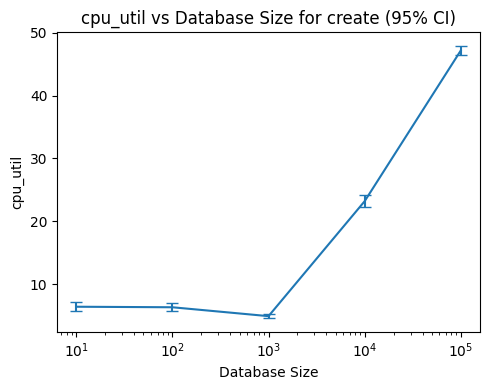

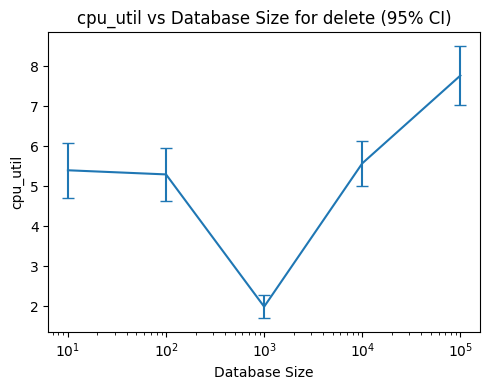

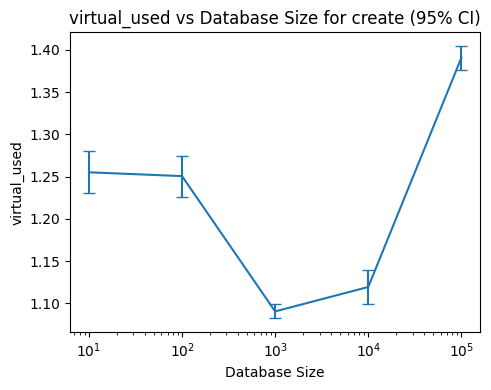

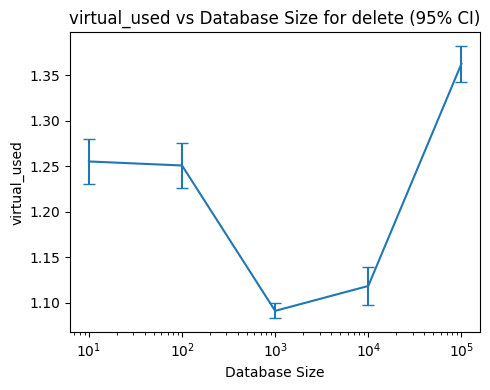

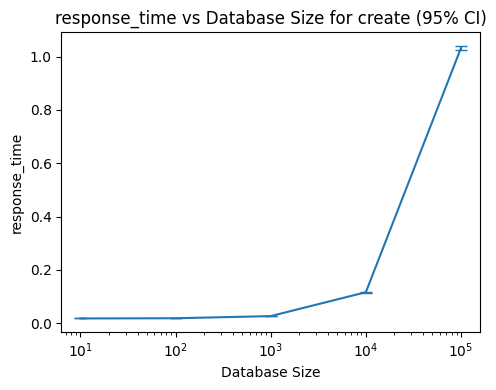

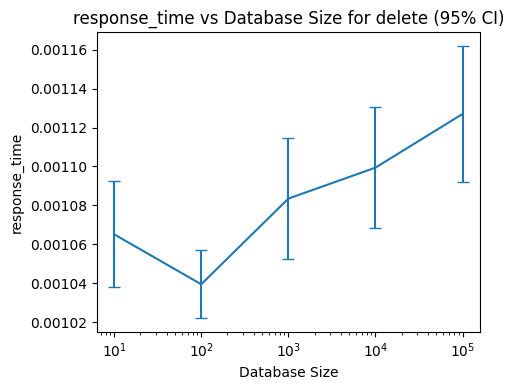

In [27]:
def plotCreateDelete(dataframe: pd.DataFrame):
    # create and delete
    operations = ["create", "delete"]

    # metrics to go through
    metrics = ["cpu_util", "virtual_used", "response_time"]
    

    # function to plot the usage to create and delete
    def plotCD(df: pd.DataFrame, operation: str, metric: str):
        # filter operation
        df = df[df["operation"] == operation]
        df = df[df["db_size"] < 10**6]

        # get the confidence interval for the metric
        df = CI(df, ["db_size"], metric)

        # extract x, y values
        x = df["db_size"]
        y = df['mean']
        
        # get the error range (CI)
        yerr = [y - df['ci_lower'], df['ci_upper'] - y]

        # create plot
        plt.figure(figsize=(5, 4))
        plt.errorbar(x, y, yerr=yerr, capsize=4)

        # format
        plt.xscale('log')
        plt.xlabel('Database Size')
        plt.ylabel(metric)
        plt.title(f'{metric} vs Database Size for {operation} (95% CI)')
        plt.tight_layout()
        plt.show()

    # go through all the pairs
    for metric in metrics:
        for op in operations:
            plotCD(dataframe.copy(deep=True), op, metric)

plotCreateDelete(e_df)

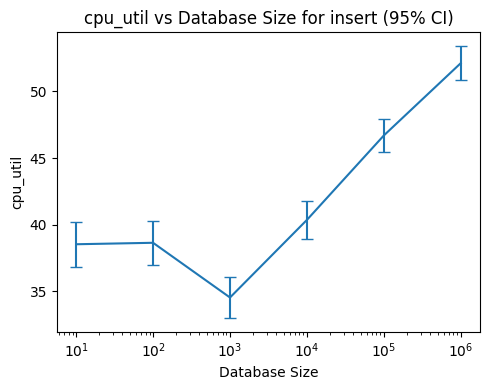

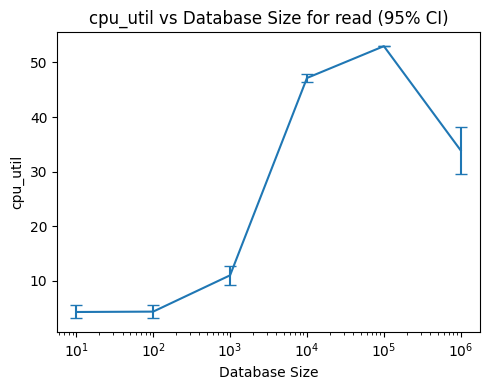

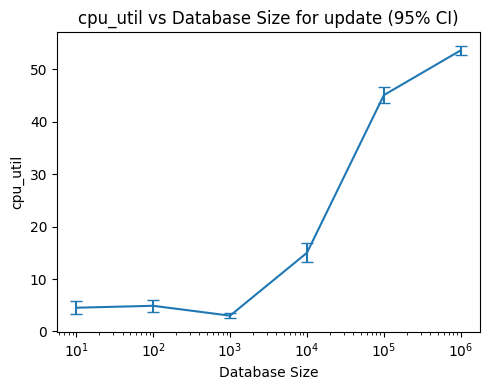

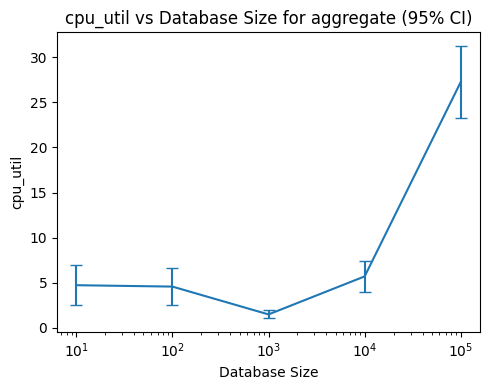

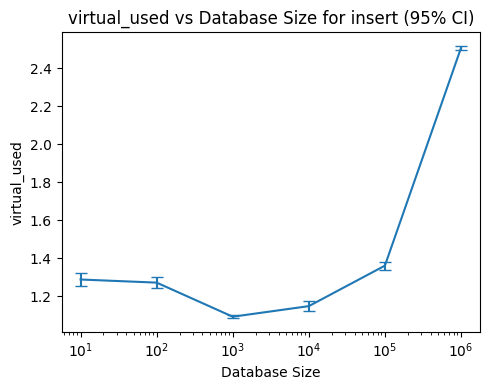

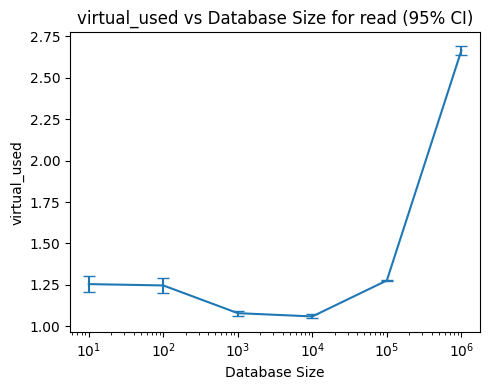

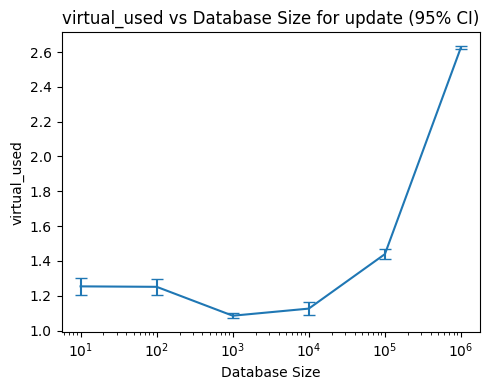

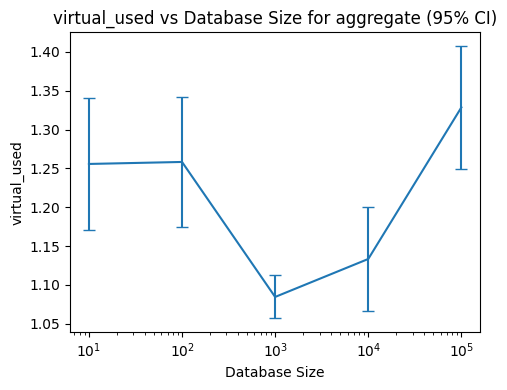

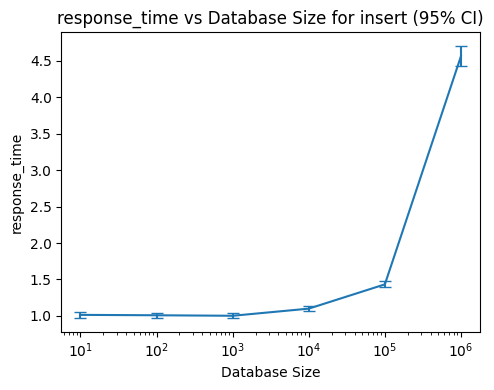

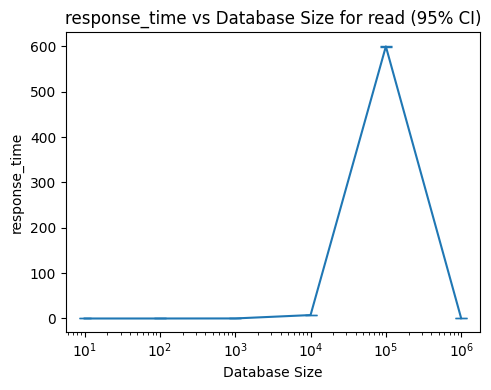

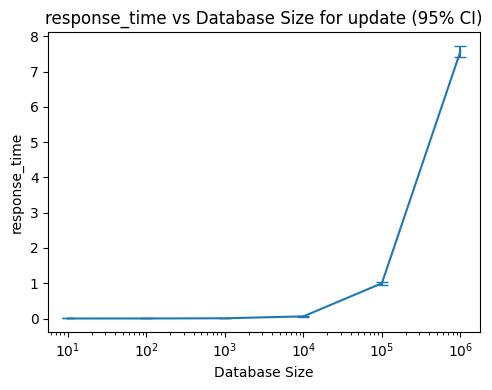

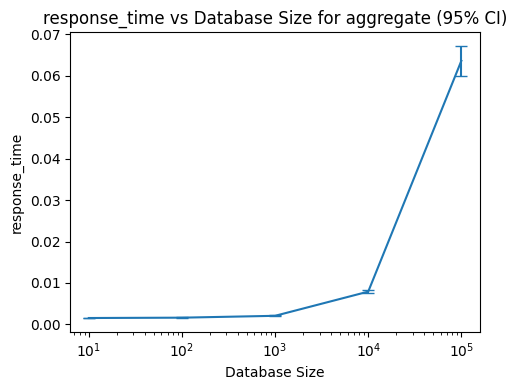

In [17]:
def plotFunctions(dataframe: pd.DataFrame):
    # key-value pairs for the name and what consitutes that operation
    fn_lut = {
        "insert": [
            'insertMany', 'insertManyThenDeleteMany', 'insertOne',
            'insertOneThenUpdateBirthday', 'insertOneThenUpdateTimestamp'
        ],
        "read": [
            'readMany', 'readOne',
            'readThenDeleteOldUsers', 'readThenDeleteManyLikes'
        ],
        "update": ['replaceOne', 'updateMany', 'updateOne'],
        "aggregate": ["aggregate"]
    }

    # metrics to look at
    metrics = ["cpu_util", "virtual_used", "response_time"]

    def plotFn(df: pd.DataFrame, metric: str, fnc: list, name: str):
        # filter
        df = df[(df["operation"] == "execute") & (df["function"].isin(fnc))]

        # calculate the confidence interval
        df = CI(df, ["db_size"], metric)

        # get the error margin, x, and y
        x = df["db_size"]
        y = df['mean']
        yerr = [y - df['ci_lower'], df['ci_upper'] - y]

        # plot
        plt.figure(figsize=(5, 4))
        plt.errorbar(x, y, yerr=yerr, capsize=4)

        # format
        plt.xscale('log')
        plt.xlabel('Database Size')
        plt.ylabel(metric)
        plt.title(f'{metric} vs Database Size for {name} (95% CI)')
        plt.tight_layout()
        plt.show()

    # traverse the pairs and plot them
    for metric in metrics:
        for key, value in fn_lut.items():
            plotFn(dataframe.copy(deep=True), metric, value, key)

plotFunctions(e_df)

___________
### Conclusions
Metrics - response time, cpu utilization, virtual memory used
Factors - Instance RAM (2 vs 4), data type (structured vs unstructured), operations (CRUD + Aggregation), data size (10 - 10^6)

Initial Question
1. What are the impacts of 2 GiB vs 4 GiB of RAM?
    - It limits the total size of the database, 2 GiB instance can not support 10^6 without crashing
        - show count vs database size
    - The more RAM the system has to use the higher the base utilization
2. What is the impact of using structured vs unstructured data?
    - There does not seem to be any impact aside from the variation of implementation
        - Create delete are identical
        - executing takes similar time
3. Which operations are most limiting? What is the scalability of each operation?
    - Create is the most limiting
    - Read is constant time
    - Create, Update, Delete increase with database size
4. Discuss impact of memory, data structure, database size and operations
__________

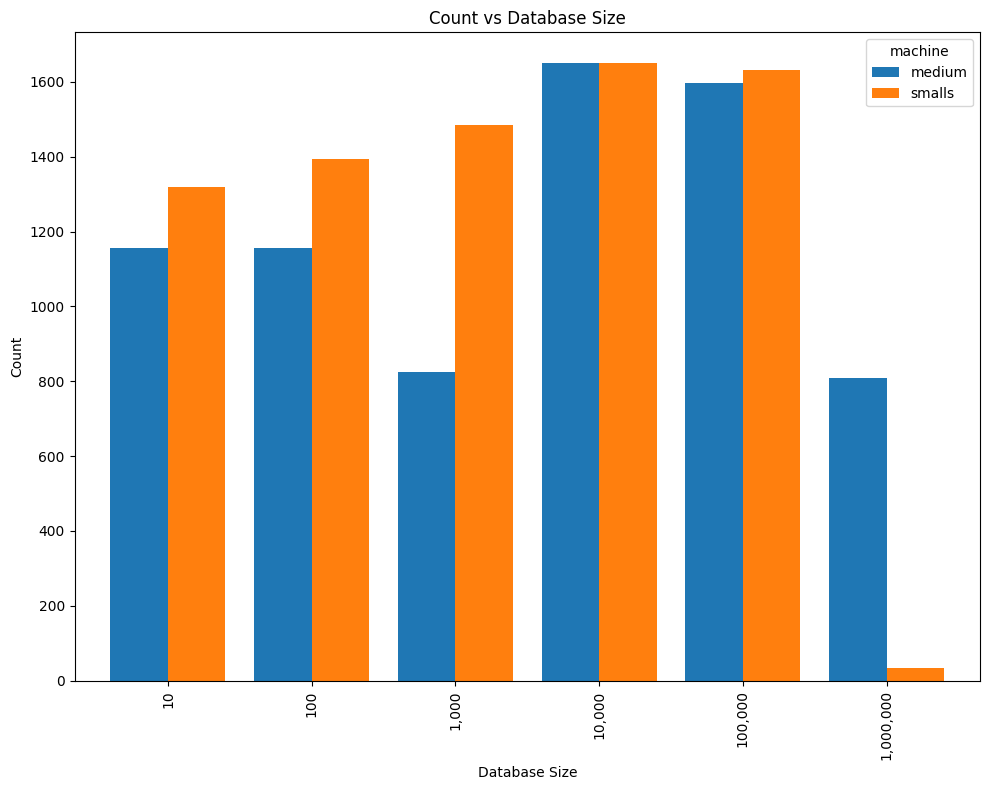

In [10]:
def machineCountBarChart(df: pd.DataFrame):
    # get the counts by db size and machine
    df = (
        df
        .groupby(['db_size','machine'])
        .size()
        .unstack()
    )

    # create a comparative barchart
    ax = df.plot(
        kind='bar',
        figsize=(10,8),
        width=0.8
    )

    # format
    ax.set_xticklabels([f"{int(x):,}" for x in df.index], rotation=90)
    ax.set_xlabel('Database Size')
    ax.set_ylabel('Count')
    ax.set_title('Count vs Database Size')
    plt.tight_layout()
    plt.show()

machineCountBarChart(t_df.copy(deep=True))

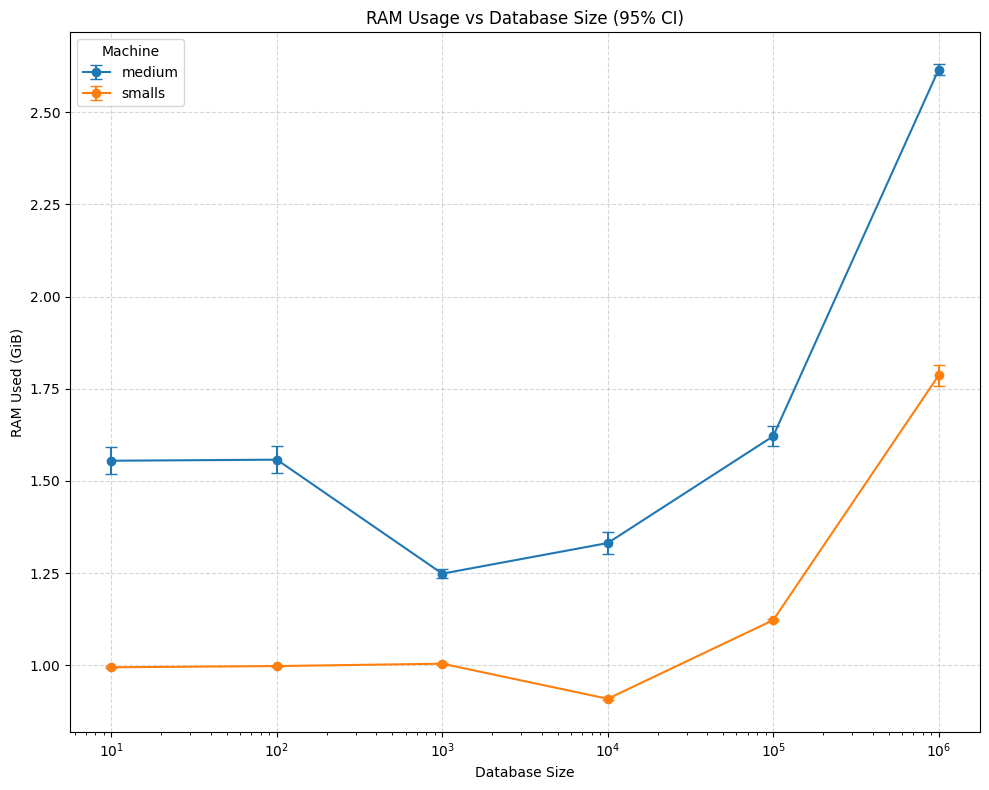

In [46]:
def ramUsageLinePlotCI(df: pd.DataFrame):
    # compute confidence interval
    ci_df = CI(df, ["machine", "db_size"], "virtual_used")

    # create plot
    plt.figure(figsize=(10, 8))

    # plot with error bars as confidence intervals
    for mach in ci_df['machine'].unique():
        sub = ci_df[ci_df['machine'] == mach].sort_values('db_size')
        x = sub['db_size']
        y = sub['mean']
        yerr = [y - sub['ci_lower'], sub['ci_upper'] - y]

        plt.errorbar(
            x, y, yerr=yerr,
            marker='o', capsize=4,
            label=mach
        )

    # format
    plt.xscale('log')
    plt.xlabel('Database Size')
    plt.ylabel('RAM Used (GiB)')
    plt.title('RAM Usage vs Database Size (95% CI)')
    plt.legend(title='Machine')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

ramUsageLinePlotCI(t_df.copy(deep=True))

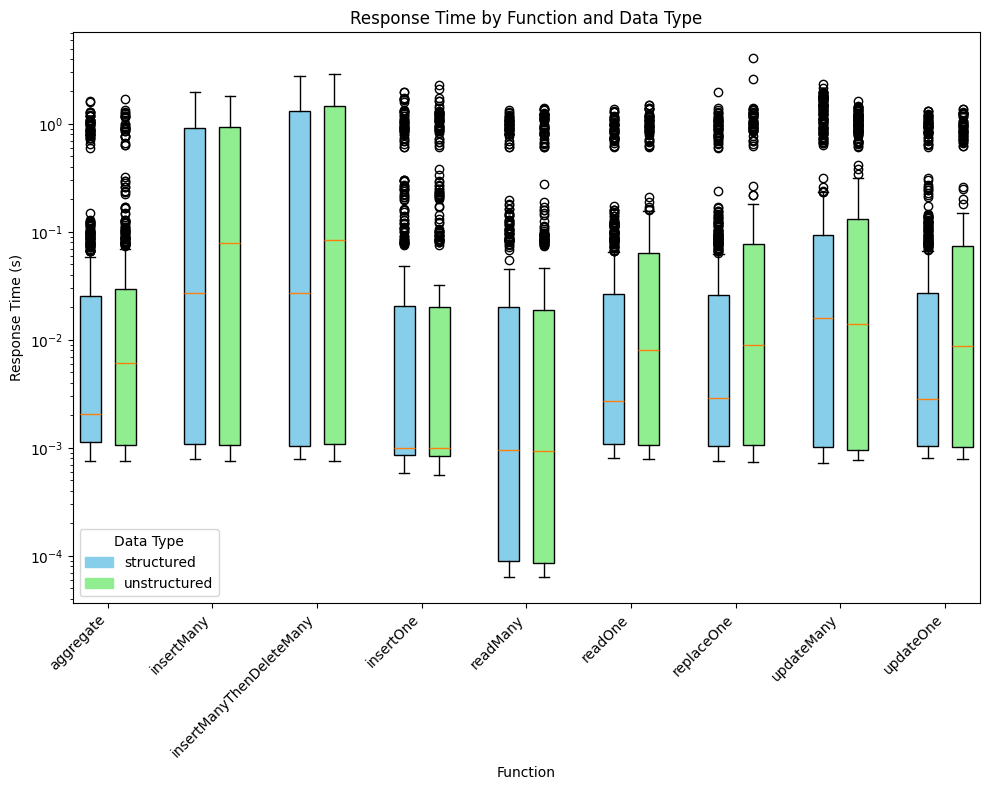

In [12]:
def functionBoxPlot(df: pd.DataFrame):
    # filter to have the most consistent data
    df = df[~df["function"].isin([
        "insertOneThenUpdateBirthday",
        "insertOneThenUpdateTimestamp",
        "readThenDeleteManyLikes",
        "readThenDeleteOldUsers",
    ])]
    df = df[df["db_size"] < 10**6]

    # collect boxplot data
    functions = df["function"].unique()
    data = []
    positions = []

    # go through functions and data type
    for i, func in enumerate(functions):
        for j, dbt in enumerate(["structured", "unstructured"]):
            # subset of data
            subset = df[(df["function"] == func) & (df["db_type"] == dbt)]["response_time"]

            # add to lists
            data.append(subset)
            positions.append(i * 3 + j)

    # Plot
    plt.figure(figsize=(10, 8))
    bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True)

    # Color boxes
    colors = ["skyblue", "lightgreen"] * len(functions)
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)

    # X-axis labels
    xticks = [i * 3 + 0.5 for i in range(len(functions))]
    plt.xticks(xticks, functions, rotation=45, ha="right")

    # format
    plt.yscale('log')
    plt.xlabel("Function")
    plt.ylabel("Response Time (s)")
    plt.title("Response Time by Function and Data Type")
    blue_patch = mpatches.Patch(color="skyblue", label="structured")
    green_patch = mpatches.Patch(color="lightgreen", label="unstructured")
    plt.legend(handles=[blue_patch, green_patch], title="Data Type")

    plt.tight_layout()
    plt.show()

functionBoxPlot(t_df.copy(deep=True))

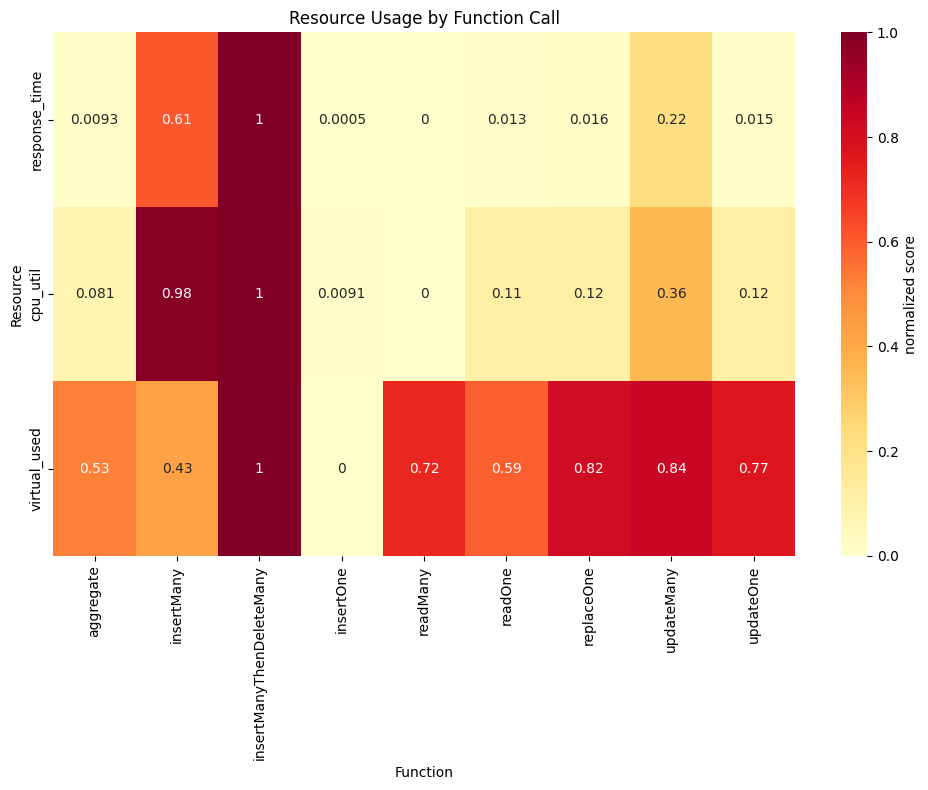

In [13]:
def usageHeatMap(df: pd.DataFrame):
    # filter functions to have ones that have both structured and unstructured
    df = df[df["function"].isin([
        'aggregate','insertMany','insertManyThenDeleteMany','insertOne',
        'readMany','readOne','replaceOne','updateMany','updateOne'
    ])]

    # filter to ignore create and delete overhead
    df = df[df["operation"] == "execute"]

    # most consistent dataset for trend
    df = df[df["db_size"] < 10**6]

    # get the mean for each function
    df = (
        df
        .groupby('function')
        .agg({
            'response_time':'mean',
            'cpu_util':'mean',
            'virtual_used':'mean'
        })
    )

    # normalize the values
    normed = (df - df.min()) / (df.max() - df.min())

    # plot heat map with normalized values
    plt.figure(figsize=(10,8))
    sns.heatmap(
        normed.T,
        annot=True,
        cmap="YlOrRd",
        cbar_kws={'label':'normalized score'}
    )

    # format
    plt.title("Resource Usage by Function Call")
    plt.xlabel("Function")
    plt.ylabel("Resource")
    plt.tight_layout()
    plt.show()

usageHeatMap(t_df.copy(deep=True))

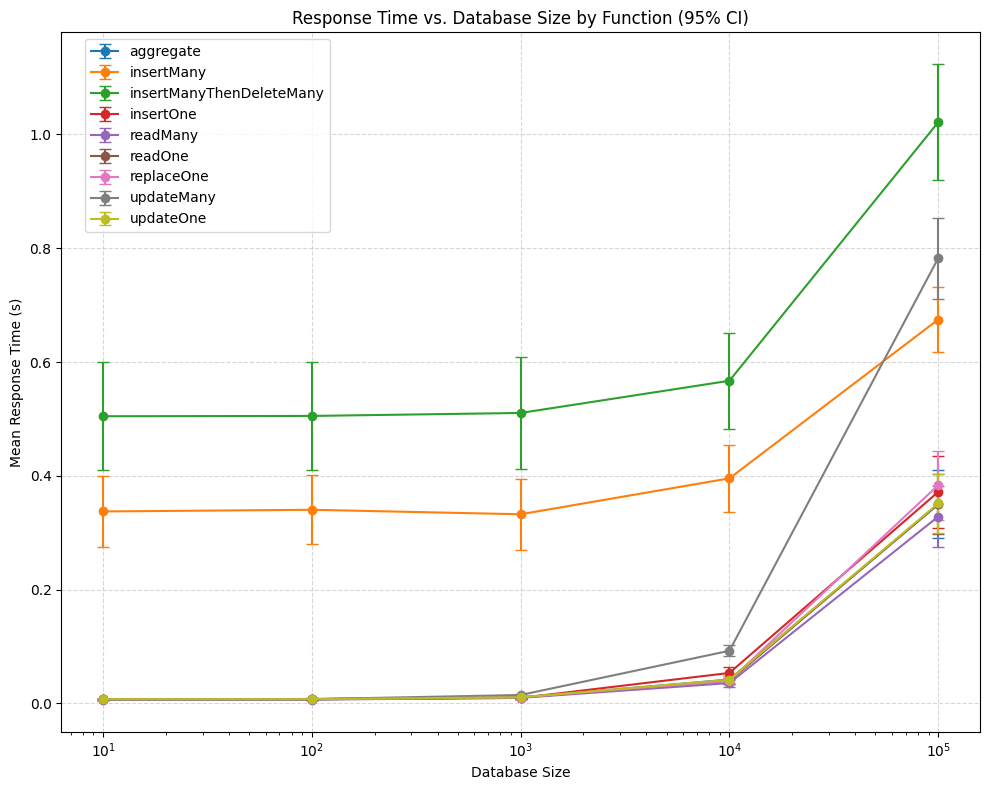

In [54]:
def rtLinePlotCI(df: pd.DataFrame):
    # filter
    functions = [
        'aggregate','insertMany','insertManyThenDeleteMany','insertOne',
        'readMany','readOne','replaceOne','updateMany','updateOne'
    ]
    df = df[df["function"].isin(functions) & (df["db_size"] < 10**6)]

    # compute confidence interval
    ci_df = CI(df, ["db_size", "function"], "response_time")

    # start figure
    plt.figure(figsize=(10, 8))

    # plot each function and its confidence interval
    for func in functions:
        sub = ci_df[ci_df["function"] == func].sort_values("db_size")
        if sub.empty:
            continue
        x = sub["db_size"]
        y = sub["mean"]
        yerr = [y - sub["ci_lower"], sub["ci_upper"] - y]

        plt.errorbar(
            x, y, yerr=yerr,
            marker='o', capsize=4,
            label=func
        )

    # format
    plt.xscale('log')
    plt.xlabel('Database Size')
    plt.ylabel('Mean Response Time (s)')
    plt.title('Response Time vs. Database Size by Function (95% CI)')
    plt.legend(bbox_to_anchor=(0.3, 1))
    plt.grid(True, ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

rtLinePlotCI(t_df.copy(deep=True))

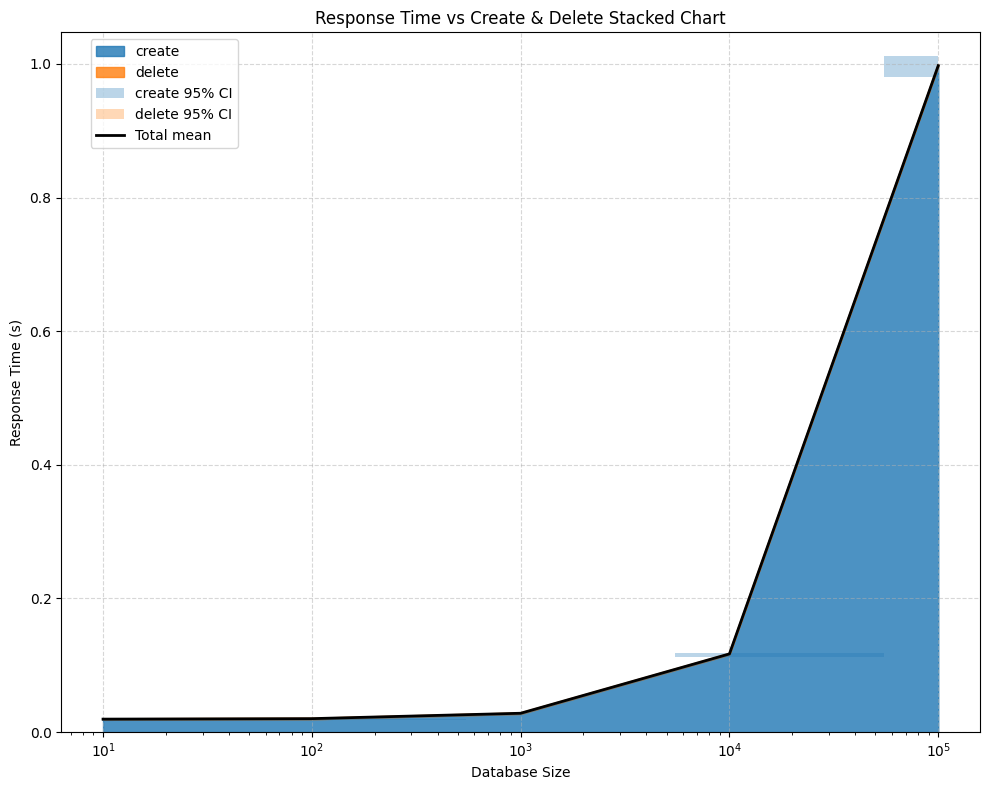

In [52]:
def createDeleteStackChartCI(df: pd.DataFrame):
    # filter
    df = df[(df["operation"] != "execute") & (df["db_size"] < 10**6)]

    # get confidence interval
    ci_df = CI(df, ["db_size", "operation"], "response_time")

    # pivot to get mean, lower and upper bound
    mean_df = (
        ci_df
        .pivot(index="db_size", columns="operation", values="mean")
        .sort_index()
    )
    lower_df = (
        ci_df
        .pivot(index="db_size", columns="operation", values="ci_lower")
        .sort_index()
    )
    upper_df = (
        ci_df
        .pivot(index="db_size", columns="operation", values="ci_upper")
        .sort_index()
    )

    # create plot
    fig, ax = plt.subplots(figsize=(10, 8))

    # stacked chart using mean
    mean_df.plot.area(
        ax=ax,
        stacked=True,
        alpha=0.8,
        legend=False
    )

    # plot confidence interval
    for op in mean_df.columns:
        ax.fill_between(
            mean_df.index,
            lower_df[op],
            upper_df[op],
            step='mid',
            alpha=0.3,
            label=f"{op} 95% CI"
        )

    # total mean line
    total_mean = mean_df.sum(axis=1)
    ax.plot(mean_df.index, total_mean, color='k', lw=2, label='Total mean')

    # format
    ax.set_xscale('log')
    ax.set_xlabel('Database Size')
    ax.set_ylabel('Response Time (s)')
    ax.set_title('Response Time vs Create & Delete Stacked Chart')
    ax.legend(loc='upper right', bbox_to_anchor=(0.2, 1.0))
    plt.grid(True, ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

createDeleteStackChartCI(t_df.copy(deep=True))